<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLatFIAN2020/blob/master/seminar08/MLatFIAN_2020_seminar08_MISC-SeminarVersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://github.com/HSE-LAMBDA/MLatFIAN2020/raw/master/seminar01/train.csv

--2020-10-27 10:22:40--  https://github.com/HSE-LAMBDA/MLatFIAN2020/raw/master/seminar01/train.csv
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2020/master/seminar01/train.csv [following]
--2020-10-27 10:22:40--  https://raw.githubusercontent.com/HSE-LAMBDA/MLatFIAN2020/master/seminar01/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.02s   

2020-10-27 10:22:41 (3.73 MB/s) - ‘train.csv’ saved [60302/60302]



In [2]:
import numpy as np
import pandas as pd

data = pd.read_csv('train.csv', index_col='PassengerId')
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=100, random_state=123)
def get_Xy(Xy):
  return Xy.drop('Survived', axis=1), Xy['Survived']

# Combining preprocessors

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

In [38]:
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),
    OneHotEncoder()
)
numecir_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RobustScaler()
)

categorical_features = ['Pclass', 'Sex', 'Embarked']
# categorical_features = [ 'Sex', 'Embarked']
numeric_features = ['Age', 'SibSp', 'Fare']

model = make_pipeline(
    make_column_transformer(
        (categorical_pipeline, categorical_features),
        (numecir_pipeline, numeric_features),
        remainder='drop'
    ),
    XGBClassifier()
)

model.fit(*get_Xy(data_train))
model.score(*get_Xy(data_test))

0.82

In [34]:
ohe = model['columntransformer'].named_transformers_['pipeline-1']['onehotencoder']
ohe.categories_

[array(['female', 'male'], dtype=object),
 array(['C', 'Q', 'S', 'unknown'], dtype=object)]

In [39]:
ohe = model['columntransformer'].named_transformers_['pipeline-1']['onehotencoder']
final_features = [
    f'{feature}_{val}'
    for feature, category_set in zip(categorical_features, ohe.categories_)
    for val in category_set
]
final_features += numeric_features
final_features

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_unknown',
 'Age',
 'SibSp',
 'Fare']

In [40]:
print(f'{"importance":12s}      {"feature":15s}')
for i in np.argsort(model[-1].feature_importances_)[::-1]:
  print(f'{model[-1].feature_importances_[i]:12.3f}      {final_features[i]:15s}')

importance        feature        
       0.429      Sex_female     
       0.226      Pclass_3       
       0.099      Pclass_1       
       0.068      SibSp          
       0.052      Embarked_S     
       0.039      Age            
       0.034      Fare           
       0.030      Embarked_C     
       0.023      Pclass_2       
       0.000      Embarked_unknown
       0.000      Embarked_Q     
       0.000      Sex_male       


# Permutation importance

In [ ]:
!pip install eli5

In [ ]:
import eli5
from eli5.sklearn import PermutationImportance

In [37]:
perm = PermutationImportance(model[-1], random_state=1)
X_test, y_test = get_Xy(data_test)
perm.fit(
    model[:-1].transform(X_test),
    y_test
)

eli5.show_weights(perm, feature_names=final_features)

Weight,Feature
0.1780 ± 0.1038,Sex_female
0.0200 ± 0.0456,SibSp
0.0200 ± 0.0126,Age
0.0000 ± 0.0179,Fare
0 ± 0.0000,Embarked_unknown
0 ± 0.0000,Embarked_Q
0 ± 0.0000,Sex_male
-0.0100 ± 0.0126,Embarked_S
-0.0120 ± 0.0150,Embarked_C


# Working with text features

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [53]:
vec = CountVectorizer(
    ngram_range=(1, 2), 
    max_df=0.7
)

text = [
  "Hi Hello! I'm Jack. What's your name?",
  "Hi! My name is Jill. Pleased to meet you!",
  "Hi Pleased to meet you too!"
]

vec.fit(text)
vec.vocabulary_

{'hello': 0,
 'hello jack': 1,
 'hi hello': 2,
 'hi my': 3,
 'hi pleased': 4,
 'is': 5,
 'is jill': 6,
 'jack': 7,
 'jack what': 8,
 'jill': 9,
 'jill pleased': 10,
 'meet': 11,
 'meet you': 12,
 'my': 13,
 'my name': 14,
 'name': 15,
 'name is': 16,
 'pleased': 17,
 'pleased to': 18,
 'to': 19,
 'to meet': 20,
 'too': 21,
 'what': 22,
 'what your': 23,
 'you': 24,
 'you too': 25,
 'your': 26,
 'your name': 27}

In [54]:
columns = np.empty(shape=len(vec.vocabulary_), dtype='object')
for k, v in vec.vocabulary_.items():
  columns[v] = k

pd.DataFrame(vec.transform(text).todense(), columns=columns)

,hello,hello jack,hi hello,hi my,hi pleased,is,is jill,jack,jack what,jill,jill pleased,meet,meet you,my,my name,name,name is,pleased,pleased to,to,to meet,too,what,what your,you,you too,your,your name
0,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,1
1,0,0,0,1,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,1,1,1,1,0,0,1,1,0,0


In [55]:
vec = CountVectorizer(
  ngram_range=(3, 4),
  analyzer='char_wb',
  max_features=100
)

vec.fit(get_Xy(data_train)[0]['Name'])

columns = np.empty(shape=len(vec.vocabulary_), dtype='object')
for k, v in vec.vocabulary_.items():
  columns[v] = k

pd.DataFrame(vec.transform(get_Xy(data_train)[0]['Name']).todense(), columns=columns)

,al,an,ch,ed,fr,ha,he,ja,jo,joh,le,ma,mar,mi,mis,mr,mr.,mrs,pe,th,wi,wil,am,an,and,ann,ard,ard,arl,art,ast,ber,cha,char,"d,",der,"e,",eli,ell,"en,",...,lli,llia,man,mar,mas,mis,miss,mr.,mr.,mrs,mrs.,"n,",nde,ne,ohn,ohn,on,"on,","on,","r,",r.,rd,ric,rs.,rs.,ry,"s,",s.,son,"son,",ss.,ss.,sso,sson,ste,"t,",ter,wil,will,"y,"
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
787,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0
788,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
789,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
model = make_pipeline(
    make_column_transformer(
      (CountVectorizer(
         ngram_range=(3, 4),
         analyzer='char_wb',
         max_features=100
       ), 'Name'),
       remainder='drop'
    ),
    XGBClassifier()
)

model.fit(*get_Xy(data_train))
model.score(*get_Xy(data_test))

0.8

In [57]:
eli5.show_weights(model)

Weight,Feature
0.2380,countvectorizer__ mr.
0.0895,countvectorizer__s.
0.0285,countvectorizer__sso
0.0234,countvectorizer__nde
0.0229,countvectorizer__mrs
0.0221,countvectorizer__ann
0.0206,"countvectorizer__e,"
0.0203,countvectorizer__ fr
0.0171,"countvectorizer__er,"
0.0164,countvectorizer__ber


In [58]:
name = X_test['Name'].iloc[0]
print(name)

eli5.show_prediction(
    model[-1], name,
    show_feature_values=True, vec=model[0].named_transformers_['countvectorizer'],
)

Johnson, Miss. Eleanor Ileen


In [59]:
name = X_test['Name'].iloc[5]
print(name)

eli5.show_prediction(
    model[-1], name,
    show_feature_values=True, vec=model[0].named_transformers_['countvectorizer'],
)

McKane, Mr. Peter David


# Numeric + Categorical + Text

In [60]:
all_columns = list(get_Xy(data_train)[0].columns)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='unknown'),
    OneHotEncoder()
)
numecir_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RobustScaler()
)
text_pipeline = CountVectorizer(
  ngram_range=(3, 4),
  analyzer='char_wb',
  max_features=100
)

categorical_features = ['Pclass', 'Sex', 'Embarked']
numeric_features = ['Age', 'SibSp', 'Fare']
text_features = 'Name'

model = make_pipeline(
    make_column_transformer(
        (categorical_pipeline, [all_columns.index(f) for f in categorical_features]),
        (numecir_pipeline, [all_columns.index(f) for f in numeric_features]),
        (text_pipeline, all_columns.index(text_features)),
        remainder='drop'
    ),
    XGBClassifier()
)

model.fit(*get_Xy(data_train))
model.score(*get_Xy(data_test))

0.81

In [61]:
model['columntransformer'].named_transformers_['pipeline-1'].get_feature_names = (
    lambda: [
      f'{feature}_{val}'
      for feature, category_set in zip(
          categorical_features,
          model['columntransformer'].named_transformers_['pipeline-1']['onehotencoder'].categories_
      ) for val in category_set
    ]
)

model['columntransformer'].named_transformers_['pipeline-2'].get_feature_names = (
    lambda: numeric_features
)

In [62]:
obj = X_test.iloc[0]
print(obj['Name'])

eli5.show_prediction(
    model[-1], obj.values,
    show_feature_values=True, vec=model['columntransformer'],
)

Johnson, Miss. Eleanor Ileen


# Calibration curve

In [63]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

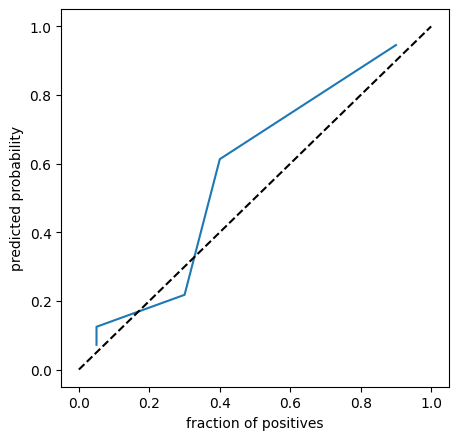

In [64]:
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(*calibration_curve(y_test, model.predict_proba(X_test)[:,1], n_bins=5, strategy='quantile'))
plt.plot([0, 1], [0, 1], '--', color='black')
plt.xlabel("fraction of positives")
plt.ylabel("predicted probability");

In [66]:
from sklearn.calibration import CalibratedClassifierCV

In [69]:
calibrated_model = make_pipeline(
    make_column_transformer(
        (categorical_pipeline, [all_columns.index(f) for f in categorical_features]),
        (numecir_pipeline, [all_columns.index(f) for f in numeric_features]),
        (text_pipeline, all_columns.index(text_features)),
        remainder='drop'
    ),
    CalibratedClassifierCV(XGBClassifier(), cv=3, method='isotonic')
)

calibrated_model.fit(*get_Xy(data_train));
calibrated_model.score(*get_Xy(data_test))

0.85

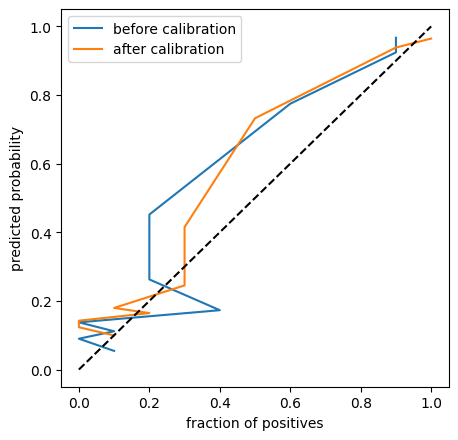

In [75]:
plt.figure(figsize=(5, 5), dpi=100)

plt.plot(*calibration_curve(y_test, model.predict_proba(X_test)[:,1], n_bins=10, strategy='quantile'),
         label='before calibration')
plt.plot(*calibration_curve(y_test, calibrated_model.predict_proba(X_test)[:,1] + np.random.normal(size=100) * 0.0001, n_bins=10, strategy='quantile'),
         label='after calibration')
plt.plot([0, 1], [0, 1], '--', color='black')
plt.xlabel("fraction of positives")
plt.ylabel("predicted probability");
plt.legend();

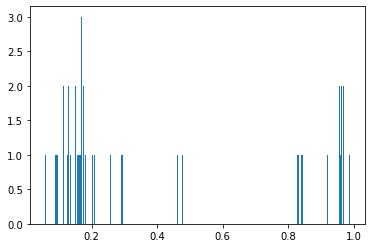

In [77]:
plt.hist(calibrated_model.predict_proba(X_test)[:,1] + np.random.normal(size=100) * 0.01, bins=1000);